# Ridge regression

## Librerie utilizzate

In [610]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.model_selection import KFold, train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from typing import List, Tuple
from LinearRegression.RidgeRegression.cholesky import Cholesky

from Utility.dataTypes import DataSet

## Analisi della banca dati
Lettura del database, tipo colonne

In [611]:
shuffleDataSet = True
RMS = 'neg_mean_squared_error'

column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
data_frame.info()
data_frame.describe()
data_frame.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Distribuzione dei valori di "median_house_value"

Text(0.5, 1.0, 'Distribuzione dei valori di "median_house_value"')

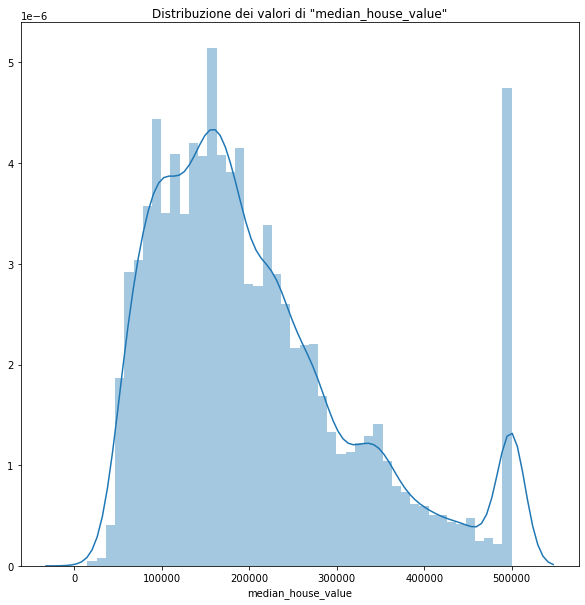

In [612]:
plt.figure(figsize=(10, 10))
seaborn.distplot(data_frame[column_to_predict])
plt.title('Distribuzione dei valori di "median_house_value"')

## Ottimizzazione banca dati
Gestione delle celle vuote e della colonna categoria "ocean_proximity"

In [613]:
# Riempe le celle vuote con la media
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

# genera le colonne per ogni elemento di una colonna categoria
columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

# elimina le colonne categoria
data_frame.drop(columns=categories_columns, inplace=True)

# aggiungi le colonne per ogni elemento di una colonna categoria
data_frame = pandas.concat([data_frame, columns_categories], axis=1)

Matrice di correlazione tra le caratteristiche

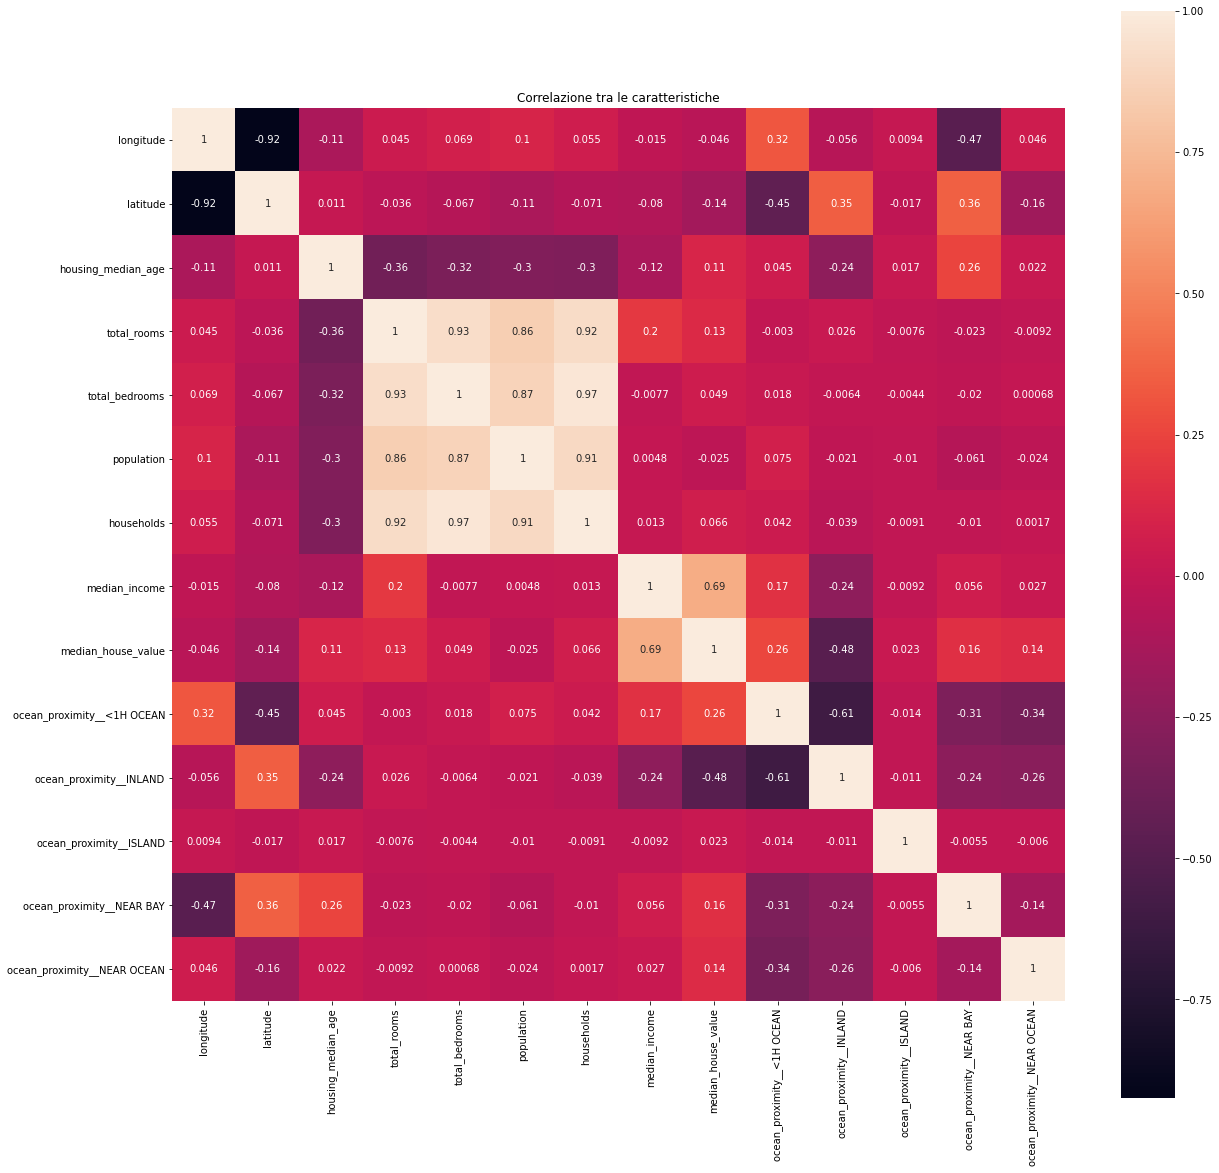

In [614]:
corr = data_frame.corr()
plt.figure(figsize=(20, 20))
plt.title('Correlazione tra le caratteristiche')
seaborn.heatmap(corr, square=True, annot=True)


Controlliamo quale caratteristica ha una correlazione maggiore di 0,75 in valore assoluto con almeno qualche altra caratteristica.

In [615]:
j = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
j

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.927253,0.857126,0.918484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.927253,NaN,0.873910,0.974725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.857126,0.873910,NaN,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.918484,0.974725,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminazione caratteristiche:
1. households che è vincolata a population
2. total_bedrooms che è vincolata a total_rooms

In [616]:
columns_to_use = list(data_frame.columns)

for u in ['households', 'total_bedrooms', column_to_predict]:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)

X = data_frame.drop(columns=['households', 'total_bedrooms', column_to_predict])
y = data_frame[column_to_predict]

## Analisi algoritmo di apprendimento

In [617]:
# sostituire con il nostro medoto
learner = Ridge(alpha=1, normalize=True)
scores = cross_val_score(learner, X, y, cv=6, scoring=RMS)
numpy.round(-scores.mean(), decimals=2)

7426370203.32

Curva apprendimento

In [618]:
sizes = range(1, 3440, 100)
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=5, scoring=RMS)

In [619]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

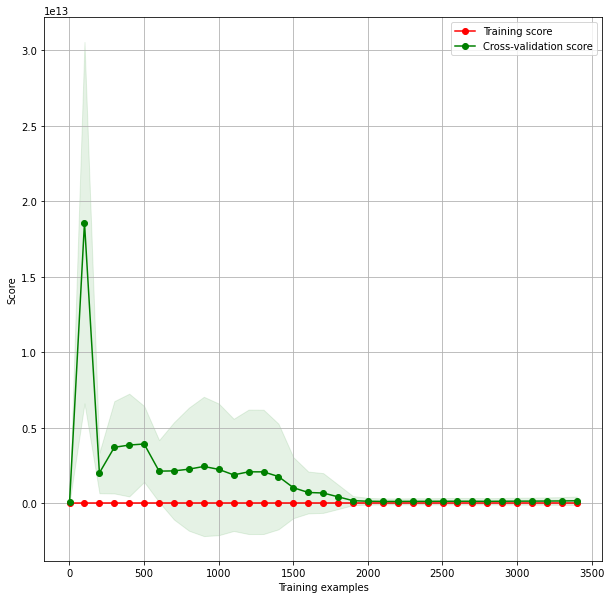

In [620]:
plt.figure(figsize=(10, 10))
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

In [621]:
coef_list = []

for s in range(150, 301, 25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, random_state=42)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

PCA

In [622]:
pca = decomposition.PCA(n_components=coef_matrix.shape[0])
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

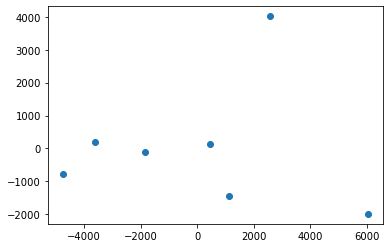

In [623]:
plt.scatter(coef_pca[:, 0], coef_pca[:, 1])

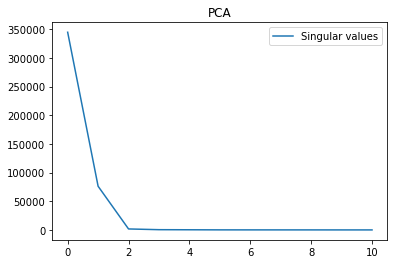

In [624]:
pca = decomposition.PCA(n_components=X.shape[1])
pca.fit(X)

plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()

We project all the datapoints on the four principal components. Then we check the learning curve again.

In [625]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)

In [626]:
sizes = range(150, 301, 25)
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [627]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

Text(0, 0.5, 'Score')

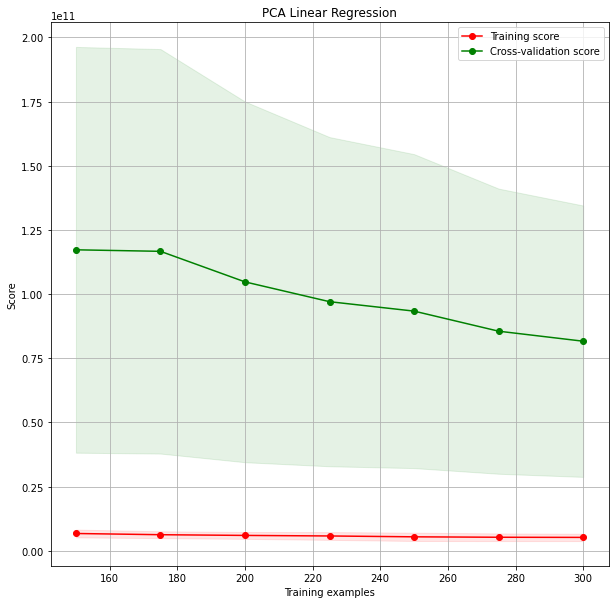

In [628]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression')
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')

In [629]:
coef_list = []

for s in range(150, 301, 25):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, random_state=42)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

In [630]:
pca = decomposition.PCA(n_components=4)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

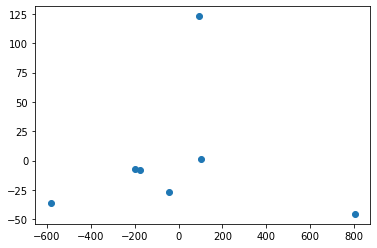

In [631]:
plt.scatter(coef_pca[:,0], coef_pca[:,1])